In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
import numpy as np

#from GW_prot import *


import sys
sys.path.insert(0,'../src')

from FGW_protein import *
import stress_comparison
import switch_probs
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib.patches as patches 
from umap.umap_ import UMAP
from sklearn.manifold import Isomap
import mpl_toolkits.axisartist.floating_axes as floating_axes


The viral RNA-dependent RNA-polymerases (RdRps) contain some circularly permuted proteins - proteins where the same motifs or domains appear in different orders along the backbone. RdRps contain three active site motifs labelled A, B and C which typically appear in the order ABC but can also appear in the order CAB. We use 'ABC' and 'CAB' to denote these two different types of RdRps.

We first load 10 proteins of each types, whose PDB files were predicted using AlphaFold.

In [2]:
dir = '../Examples/Examples Data/Example 3/'
file_list = os.listdir(dir)
ABC_prots = [FGW_protein.make_protein_from_pdb(dir + file) for file in file_list[:10]]
CAB_prots = [FGW_protein.make_protein_from_pdb(dir + file) for file in file_list[10:]]

We then create a `stress_comparison.Stress_Comparison` object and run GW all-vs-all in it.

In [3]:
A = stress_comparison.Stress_Comparison(prot_list=ABC_prots + CAB_prots)
A.GW_compute_stresses()

If we look at the transport plan between two ABC proteins or two CAB proteins, we see that it is very similar to the identity matrix, meaning that the alignment given by GW is nearly just the sequential alignment.

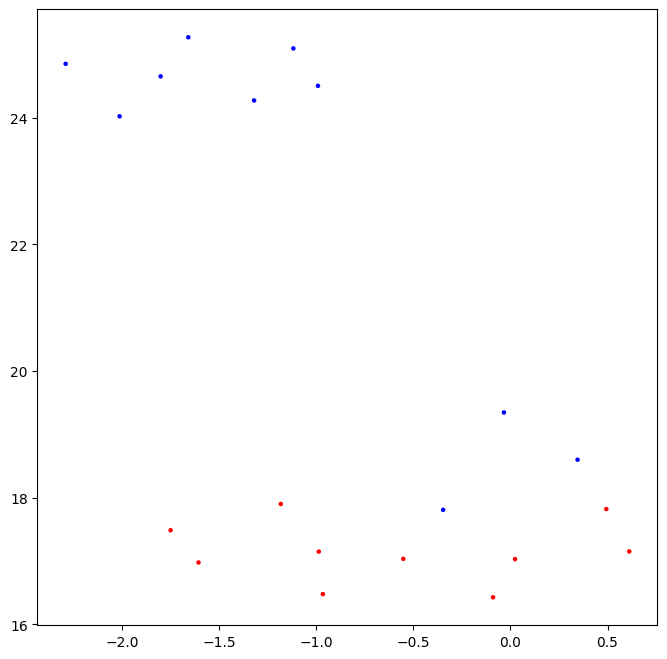

In [4]:
reducer = UMAP(metric = 'precomputed')
embedding = reducer.fit_transform(A.get_GW_dmat())
plt.figure(figsize=(8,8)) 
plt.scatter(embedding[:,0] ,embedding[:,1], color = ['red']*10 + ['blue']*10, s = 5)

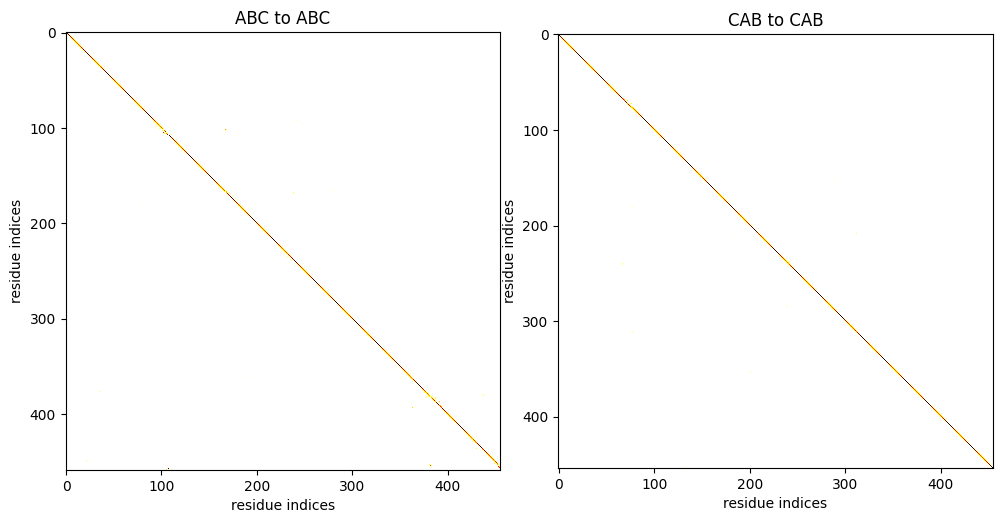

In [6]:
fig , axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
fig.tight_layout()

# two ABC proteins
axes[0].imshow(A.transport_dict[A.name_list[0]][A.name_list[1]], cmap = 'hot_r')
axes[0].set_title('ABC to ABC')
axes[0].set_xlabel('residue indices')
axes[0].set_ylabel('residue indices')


#two CAB proteins
axes[1].imshow(A.transport_dict[A.name_list[10]][A.name_list[11]], cmap = 'hot_r')
axes[1].set_title('CAB to CAB')
axes[1].set_xlabel('residue indices')
axes[1].set_ylabel('residue indices')
plt.show()



In contrast if we look at the transport plan between an ABC protein and a CAB protein it is close to being the identity matrix aside from 

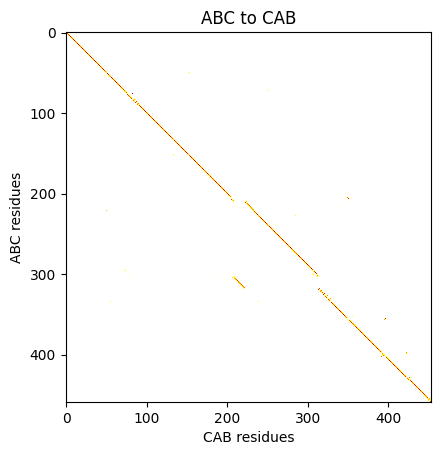

In [7]:
plt.imshow(A.transport_dict[A.name_list[0]][A.name_list[10]], cmap = 'hot_r', label = 'ABC to CAB')
plt.title('ABC to CAB')
plt.xlabel('CAB residues')
plt.ylabel('ABC residues')
plt.show()

In pymol we can visualized the transport plan. `pymol_protein_viewer.compare_proteins_in_pymol` uses `weighted_alignment.weighted_RMSD` to superimpose the two proteins minimizign weighted RMSD. `compare_proteins_in_pymol` allows displays dashes between pairs of aligned residues.

In [8]:
import importlib
importlib.reload(switch_probs)

<module 'switch_probs' from '/home/elijah/dropbox3/Analyses/PGC020.a12/Examples/../src/switch_probs.py'>

In [9]:
import pymol_protein_viewer
pymol_protein_viewer.compare_proteins_in_pymol(
    file1 = dir + file_list[0], 
    file2 = dir + file_list[10],
    chain1 ='A', 
    chain2 ='A', 
    transport_plan=A.transport_dict[A.name_list[0]][A.name_list[10]], 
    output_file= 'Example3.pse') 

In this screenshot we see the two proteins overlaid. The ABC protein is in green and the CAB protein in blue, the redder sections indicate areas with higher stress levels. The transport plan is shown by the yellow lines between paired residues.

![Screenshot4.PNG](Screenshot4.PNG)

We can use `switch_probs.get_switch_prob` to see which residues are switched and  `switch_probs.visualize_switch_probabibilities` for visualization.


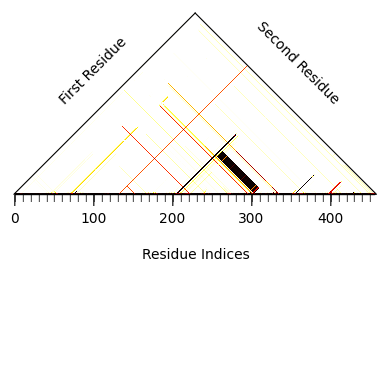

In [10]:
switch_probs.visualize_switch_probabibilities(switch_probs.get_switch_prob(A.transport_dict[A.name_list[0]][A.name_list[10]], prot_num=0))

The white and light-colored areas represent pairs of residues whose orders are preserved and the dark rectangles are pairs whose orders are switched. `prot_num = 0` means these are the residues of the 0th protein of these two, `A.prot_list[0]` which is an ABC protein. From the largest dark rectangle in the plot we can see that residues 211-303 switch with residues 305-318. Indeed these include the region from A to B and C respectively. 

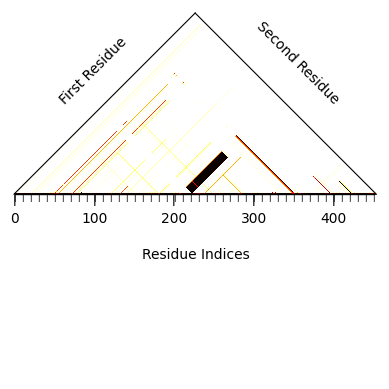

In [11]:
switch_probs.visualize_switch_probabibilities(switch_probs.get_switch_prob(A.transport_dict[A.name_list[0]][A.name_list[10]], prot_num=1))

The white and light-colored areas represent pairs of residues whose orders are preserved and the dark rectangles are pairs whose orders are switched. `prot_num = 1` means these are the residues of the 1st protein of these two, `A.prot_list[10]` which is a CAB protein. From the plot we can see that residues 209-222 switch with residues 224-313. Indeed these include the C region and region from A to B  respectively.

Using `switch_probs.preprocess` and `switch_probs.max_rectangle_diagonal` we can find the size of the largest such rectangle for each pair of proteins. This can indicate whether two proteins have the same or different permutation types.


In [12]:
switch_score_mat = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        if i ==j:
            continue

        T = A.transport_dict[A.name_list[i]][A.name_list[j]]

        #To do - rewrite this based on newer code
        SP0 = switch_probs.get_switch_prob(T)
        SP1 = switch_probs.preprocess(SP0)
        #SP1 = np.triu(1 - switch_probs.preprocess_smooth(SP0)) 
        s = switch_probs.max_rectangle_diagonal(SP1)[0]
        switch_score_mat[i,j] = s


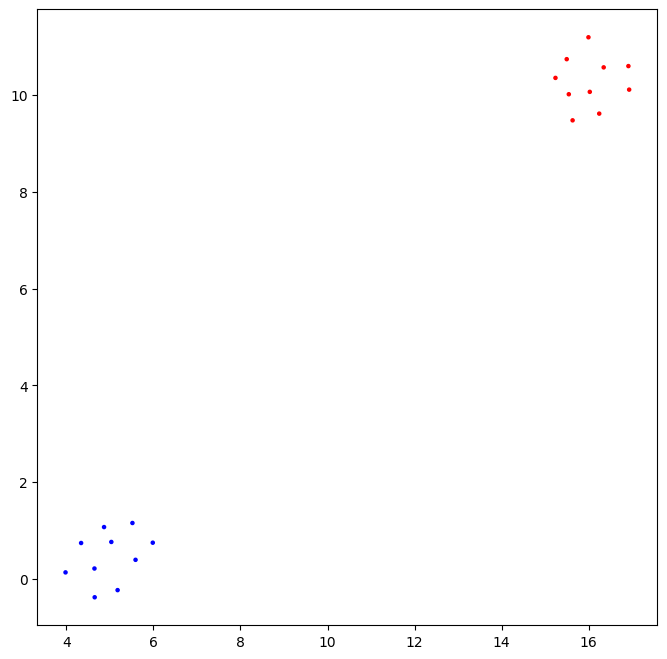

In [13]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
reducer = UMAP(metric = 'precomputed')
embedding = reducer.fit_transform(switch_score_mat + switch_score_mat.T)
plt.figure(figsize=(8,8)) 
plt.scatter(embedding[:,0] ,embedding[:,1], color = ['red']*10 + ['blue']*10, s = 5)

In [17]:
from sklearn.metrics import silhouette_score # higher is better, 0 is overlapping
from sklearn.metrics import davies_bouldin_score #lower is better
N = 20


print(f"Silhouette Score: {silhouette_score(X = A.get_GW_dmat(), labels = [0 if i <N/2 else 1 for i in range(N)], metric='precomputed')}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(A.get_GW_dmat(), labels = [0 if i <N/2 else 1 for i in range(N)])}")


print(f"Silhouette Score: {silhouette_score(X = switch_score_mat + switch_score_mat.T, labels = [0 if i <N/2 else 1 for i in range(N)], metric='precomputed')}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(switch_score_mat + switch_score_mat.T, labels = [0 if i <N/2 else 1 for i in range(N)])}")

    

Silhouette Score: 0.27379933681149565
Davies-Bouldin Score: 1.0566293884385867
Silhouette Score: 0.7821752433837325
Davies-Bouldin Score: 0.31599518873816934
